# 1. Introduction and Problem Context

This notebook is part of a Kaggle competition where the goal is to build a machine learning model that predicts whether a Tweet is about a real disaster or not. As of writing this notebook, the model is ranked 58th out of 924 in the competition leaderboard.

**Note:** This is my first time working with Large Language Models (LLMs).

**Approach Overview**
This is a binary classification task in the domain of supervised learning, using textual data as input. The key evaluation metric is the F1 score.

In this notebook, I explore two techniques to solve the problem:

1.   **Fine-tuning a DistilBERT** Pretrained Model
This approach involves applying transfer learning using a transformer model from the Hugging Face transformers library. The output from this model is used for submission to the competition.

2.   Using **Hidden States** from DistilBERT with **Logistic Regression**
Here, I extract the hidden states from the model without performing gradient descent. These embeddings are then used as features in a logistic regression classifier to compare the results with the fine-tuning approach.

Both techniques share the same tokenization phase, using the DistilBERT **Tokenizer** from the Hugging Face hub.

**Additional Work**

*   Exploratory Data Analysis (EDA)
*   Data Cleaning: While data cleaning can enhance performance, the results in this case are very close even without it. Hence, it is **optional** for this problem

# 2. Loading Data

### 2.1 Loading packages

In [ ]:
%%capture
!pip install datasets

In [ ]:
import re
import html
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer,AutoModel,TFAutoModelForSequenceClassification,TFAutoModel
from datasets import Dataset

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix

from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.parallel")

from datasets import disable_progress_bar
disable_progress_bar()

### 2.2 Loading data

The "Text" column contains the tweets, so it serves as our feature, while the "labels" column contains the class to predict, making it our target. Only these fields will be used in this work.

In [ ]:
import os
import pandas as pd  # Data processing, CSV file I/O
if 'KAGGLE_URL_BASE' in os.environ:
  for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
      print(os.path.join(dirname, filename))
  df_train_val_raw=pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
  df_test_raw=pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')
else:
  df_train_val_raw=pd.read_csv('/content/train.csv')
  df_test_raw=pd.read_csv('/content/test.csv')

df_train_val_raw = df_train_val_raw.rename(columns={"target":"labels"})
df_test_raw = df_test_raw.rename(columns={"target":"labels"})

df_train_raw, df_val_raw = train_test_split(df_train_val_raw, test_size=0.2, random_state=42)
print("shape train:", df_train_raw.shape)
print("shape val:", df_val_raw.shape)
print("shape test:", df_test_raw.shape)


/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv
shape train: (6090, 5)
shape val: (1523, 5)
shape test: (3263, 4)


In [ ]:
df_train_val_raw.head(3)

,id,keyword,location,text,labels
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1


# 3. EDA

In this section, we analyzed the dataset to understand its characteristics.
1.   We found that disaster tweets ("1") are the minority class, which could affect model performance, so we will use class weights during training.
2.   Tweets in the disaster class tend to be slightly shorter, but there is no significant difference in word count.
3.   A word cloud revealed frequent words like "fire", "flood", and "killed" in disaster tweets, while irrelevant words such as "http" will be removed during cleaning.
4.   We analyzed @name mentions, but no clear relationship was found between mentions and class, as the number of mentions was low or repeated across both classes.
5.   We also checked how the DistilBERT tokenizer handles hashtags. It splits hashtags like "#DeepLearning" into "#" and "DeepLearning", preserving their meaning. Therefore, no additional transformations are needed during the cleaning process.

## 3.1 Class distribution

We can see that tweets labeled with "1" (disasters) represent the minority class. Since the key evaluation metric is the F1 score, our focus will be on predicting disaster tweets. The imbalance in class distribution could negatively affect the model's ability to learn to identify them properly. To mitigate this, we will use class weights during model training.

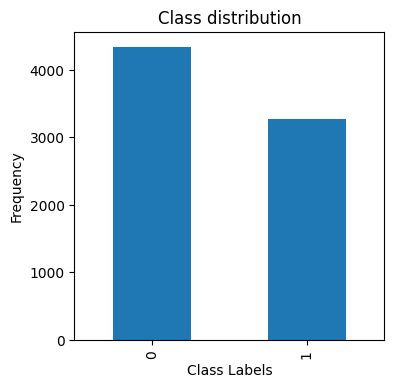

In [ ]:
plt.figure(figsize=(4,4))
df_train_val_raw["labels"].value_counts().plot(kind="bar")
plt.title("Class distribution")
plt.xlabel("Class Labels")
plt.ylabel("Frequency")
plt.show()

## 3.2 Number of words in tweets

By checking the number of words in tweets for both the disaster and normal classes, we can see no significant difference. However, disaster tweets tend to be very slightly shorter.

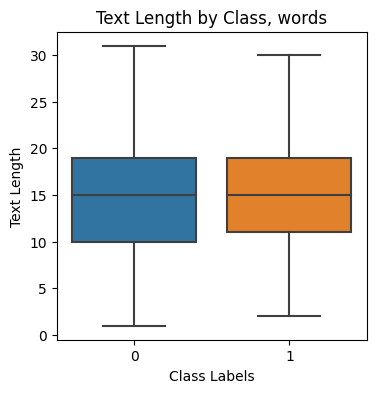

In [ ]:
df_train_val_raw["text_len"]=df_train_val_raw['text'].apply(lambda tex: len(tex.split()))

plt.figure(figsize=(4,4))
sns.boxplot(data=df_train_val_raw,x="labels",y="text_len")
plt.title("Text Length by Class, words")  # Añade un título descriptivo
plt.xlabel("Class Labels")  # Etiqueta para el eje X
plt.ylabel("Text Length")  # Etiqueta para el eje Y
plt.show()

## 3.3 WordCloud

With the word cloud, we can visually evaluate the most frequent words in both classes: normal and disaster. It makes sense that for the disaster class, some of the most frequent words are "fire", "flood", and "killed". However, there are also some words like "http" that need to be removed. We will handle this during the cleaning process.

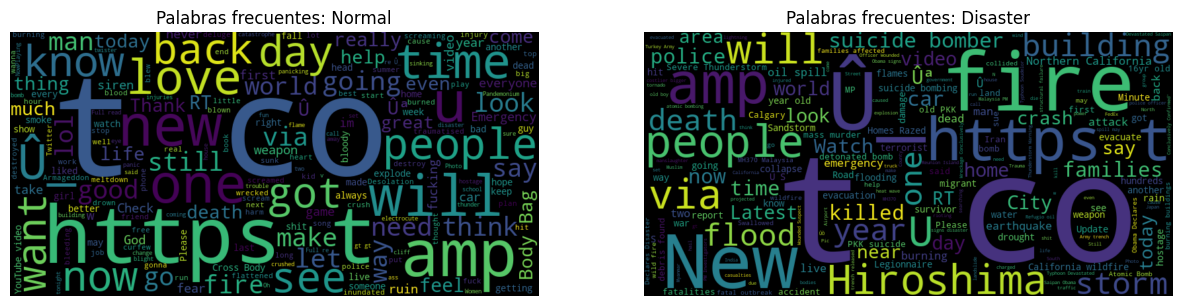

In [ ]:
from collections import Counter
from wordcloud import WordCloud

df=df_train_val_raw.copy()

def remove_hashtags(text):
    return re.sub(r'#', '', text)

df['text'] = df['text'].apply(remove_hashtags)

normal_tweets = ' '.join(df[df['labels'] == 0]['text'])
disaster_tweets = ' '.join(df[df['labels'] == 1]['text'])

wordcloud_normal = WordCloud(width=800, height=400).generate(normal_tweets)
wordcloud_disaster = WordCloud(width=800, height=400).generate(disaster_tweets)

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_normal, interpolation='bilinear')
plt.title('Class Normal')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_disaster, interpolation='bilinear')
plt.title('Class: Disaster')
plt.axis('off')

plt.show()

Filtering the text to understand why "u" is a frequent word in English. Since English is not my first language, I wasn't sure, but it seems that it means "you". Therefore, we will leave it as is.

In [ ]:
# Filter tweets containing Patterns
def filter_tweets_by_pattern(df, pattern):
    return df[df['text'].str.contains(pattern, regex=True, na=False)]

# Patterns to search for
pattern_u_ = r'(?<=\s)u(?=\s)'
pattern_tilde = r'[áéíóú]'

tweets_with_u_ = filter_tweets_by_pattern(df_train_val_raw, pattern_u_)
tweets_with_tilde = filter_tweets_by_pattern(df_train_val_raw, pattern_tilde)

print("tweets_with_u_ : ")
print(tweets_with_u_["text"].head(3))
print("________________")
print("tweets_with_u_tilde : ")
print(tweets_with_tilde["text"].head(3))

tweets_with_u_ : 
419                                @Casper_rmg u on dick
436    @local_arsonist I guess u can say that it's ju...
736    @SoDamnTrue  we know who u are you're a bleedi...
Name: text, dtype: object
________________
tweets_with_u_tilde : 
Series([], Name: text, dtype: object)


## 3.4 Frequency of "@name" Mentions

I want to analyze the most frequent "@name" mentions in both classes, to see if there is any relationship that could help with prediction. To do this, I visualize the top 10 mentions in each class. However, I don't observe any clear relationship, as the number of mentions is very low, or they are repeated across both classes.

In [ ]:

from collections import Counter

def get_top_mentions(df, label_value, top_n=10):
    """
    Extract mentions from tweets with a specific label value
    and return the most common mentions.

    Args:
    - df: The dataframe containing tweets and labels.
    - label_value: The label value used to filter tweets.
    - top_n: The number of top mentions to return (default is 10).

    Returns:
    - A list of the top_n most common mentions along with their frequencies.
    """
    # Filter the tweets with the specified label value
    tweets_with_label = df[df['labels'] == label_value]['text']

    # Regular expression to extract mentions
    mention_pattern = r'@\w+'
    all_mentions = []

    # Extract mentions from each tweet
    for tweet in tweets_with_label:
        mentions = re.findall(mention_pattern, tweet)
        all_mentions.extend(mentions)

    # Count the mentions
    mention_counts = Counter(all_mentions)

    # Get the top_n most common mentions
    top_mentions = mention_counts.most_common(top_n)

    return top_mentions

Normal class:

In [ ]:
get_top_mentions(df_train_val_raw, 0, top_n=10)

[('@YouTube', 65),
 ('@ArianaGrande', 11),
 ('@djicemoon', 7),
 ('@emmerdale', 7),
 ('@justinbieber', 7),
 ('@MikeParrActor', 6),
 ('@Change', 5),
 ('@Stretcher', 5),
 ('@invalid', 5),
 ('@Towel', 5)]

Disaster class:

In [ ]:
get_top_mentions(df_train_val_raw, 1, top_n=10)

[('@YouTube', 17),
 ('@FoxNews', 8),
 ('@POTUS', 6),
 ('@AP', 5),
 ('@USAgov', 5),
 ('@Change', 4),
 ('@unsuckdcmetro', 4),
 ('@ViralSpell', 3),
 ('@usatoday', 3),
 ('@Michael5SOS', 3)]

## 3.5 Handling of Hashtags by DistilBERT Tokenizer

Hashtags can be important for text classification. By checking how the DistilBERT tokenizer handles them, we observe that a hashtag like "#DeepLearning" is split into "#" and the parts of the word "DeepLearning". This means that hashtags retain their meaning during tokenization, so no additional transformations are needed during the cleaning process.

In [ ]:
from transformers import AutoTokenizer

# Load the tokenizer
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

# Example text with hashtags
text = "@usuario, Learning #DeepLearning and #MachineLearning"
text_without = "@usuario, Learning DeepLearning and #MachineLearning"

# Tokenize the text
tokens = tokenizer.tokenize(text)
tokens_without = tokenizer.tokenize(text_without )
print("Tokens with #:", tokens)
print("Tokens without:", tokens_without)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Tokens with #: ['@', 'us', '##ua', '##rio', ',', 'learning', '#', 'deep', '##lea', '##rn', '##ing', 'and', '#', 'machine', '##lea', '##rn', '##ing']
Tokens without: ['@', 'us', '##ua', '##rio', ',', 'learning', 'deep', '##lea', '##rn', '##ing', 'and', '#', 'machine', '##lea', '##rn', '##ing']


## 4. Data Cleaning (Optional)

The following text cleaning transformations were applied, but in my case, they only slightly improved the model's results. Therefore, the model can be used without them:

*   Remove HTML entities: Decodes HTML entities (e.g., &amp; to &).
*   Convert to lowercase: Standardizes the text by converting all characters to lowercase.
*   Remove URLs: Removes URLs (e.g., http://example.com).
*   Remove mentions: Removes user mentions (e.g., @username).
*   Remove HTML tags: Strips HTML tags (e.g., "< div >").
*   Remove special characters: Eliminates non-alphabetic characters (except spaces).
*   Normalize white spaces: Reduces multiple spaces to a single space and removes leading/trailing spaces.

In [ ]:
# Define regular expression patterns for URLs, mentions, hashtags, and special characters
url_pattern =r'https?://\S+|www\.\S+' # r'http\S+|www\S+'
mention_pattern = r'@\w+'
HTML_tags_pattern = r'<.*?>'
special_chars_pattern = r'[^a-zA-Z\s]'

# Function to clean HTML entities
def remove_html_entities(text):
    return html.unescape(text)

# Text cleaning function
def clean_tweet(text):
    text = remove_html_entities(text)  # Remove HTML entities from the text
    # Convert to lowercase
    text = text.lower()

    # Remove URLs from the text
    text = re.sub(url_pattern, '', text)

    # Remove mentions (@username) from the text
    text = re.sub(mention_pattern, '', text)

    # Remove HTML tags from the text
    text = re.sub(HTML_tags_pattern, '', text)

    # Normalize white spaces (remove extra spaces and leading/trailing spaces)
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [ ]:
df_train_clean=df_train_raw.copy()
df_val_clean=df_val_raw.copy()
df_test_clean =df_test_raw.copy()

for df in [df_train_clean, df_val_clean,df_test_clean ]:
    df['text'] = df['text'].apply(clean_tweet)

df_train_clean['text'].head()

4996    courageous and honest analysis of need to use ...
3263    wld b a shame if that golf cart became engulfe...
4907    tell to rescind medals of 'honor' given to us ...
2855    worried about how the ca drought might affect ...
4716                lava blast & power red #pantherattack
Name: text, dtype: object

# 5 Model Selection and Tokenization

## 5.1 Model Selection

BERT is widely used for text classification tasks due to its high performance. In this case, we will apply DistilBERT, a smaller and more efficient variation of BERT. As described in the article, DistilBERT is a lightweight, fast, and inexpensive Transformer model trained by distilling BERT base. It has 40% fewer parameters than the original Google BERT (bert-base-uncased), runs 60% faster, and maintains over 95% of BERT’s performance as measured on the GLUE language understanding benchmark

In [ ]:
model_ckpt = "distilbert-base-uncased"

In [ ]:
#using cleaned data
df_train=df_train_clean.copy()
df_val=df_val_clean.copy()
df_test=df_test_clean.copy()

#using  data without cleaning
#df_train=df_train_raw.copy()
#df_val= df_val_raw.copy()
#df_test=df_test_raw.copy()

We will be using the pre-trained DistilBERT model from Hugging Face, so we will convert the dataset into Hugging Face Dataset objects for efficient processing and tokenization. This allows us to seamlessly integrate with the model and take advantage of the framework's optimized handling of text data.

In [ ]:
dataset_train = Dataset.from_pandas(df_train)
dataset_val = Dataset.from_pandas(df_val)
dataset_test = Dataset.from_pandas(df_test)

In [ ]:
dataset_train

Dataset({
    features: ['id', 'keyword', 'location', 'text', 'labels', '__index_level_0__'],
    num_rows: 6090
})

## 5.2 Tokenization

We use the **Hugging Face AutoTokenizer** to preprocess the text data. The tokenizer converts text into token IDs, adding special internal tokens, and applies padding and truncation as needed. The maximum sequence length is determined from the training data, and all datasets (train, validation, and test) are tokenized accordingly to ensure consistency for model input. The tokenization process is applied in batches

In [ ]:
# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

# Define the tokenization function
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

# Tokenize the training dataset
train_encoded = dataset_train.map(tokenize, batched=True)

# Calculate the length of each 'input_ids' sequence in the training dataset
input_ids_lengths = [len(input_ids) for input_ids in train_encoded["input_ids"]]

# Find the maximum length of the 'input_ids' sequences
max_input_ids_length = max(input_ids_lengths)
max_input_ids_length

80

In [ ]:
# Define the tokenization function with a maximum sequence length
def tokenize_max_len(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=max_input_ids_length)

# Tokenize the datasets in batches (train, validation, and test)
train_encoded = dataset_train.map(tokenize_max_len, batched=True)
val_encoded = dataset_val.map(tokenize_max_len, batched=True)
test_encoded = dataset_test.map(tokenize_max_len, batched=True)

# 6. Model Training

I explore two techniques to solve the problem:

*   6.1 Using **Hidden States** from DistilBERT with **Logistic Regression**
Here, I extract the hidden states from the model without performing gradient descent. These embeddings are then used as features in a logistic regression classifier to compare the results with the fine-tuning approach.
*   6.2. **Fine-tuning a DistilBERT** Pretrained Model
This approach involves applying transfer learning using a transformer model from the Hugging Face transformers library. The output from this model is used for submission to the competition.

Both techniques share the same tokenization phase, using the DistilBERT **Tokenizer** from the Hugging Face hub.

## 6.1 Using **Hidden States** from DistilBERT with **Logistic Regression** (for comparison)

In this section, we extract hidden states from the pre-trained DistilBERT model and use them for classification with logistic regression.

*   Model loading: The pre-trained DistilBERT model is loaded using TFAutoModel.from_pretrained(model_ckpt).
*   Extracting hidden states: A function is defined to extract the hidden state of the [CLS] token, which serves as the feature representation for each text.
*   Model evaluation: The extracted hidden states are used as inputs for logistic regression to evaluate DistilBERT's representations without fine-tuning.

It was observed that scaling the hidden states slightly worsens the model's predictions, so they are used directly without any transformation.

### 6.1.1 Extracting hidden states

In [ ]:
# Load the pre-trained DistilBERT model
model = TFAutoModel.from_pretrained(model_ckpt)

# Function to extract hidden states from the model
def extract_hidden_states(batch):
    inputs = {k: tf.constant(v) for k, v in batch.items() if k in tokenizer.model_input_names}

    # Pass the inputs through the model to obtain the hidden states
    outputs = model(**inputs)

    # Extract the vector of the [CLS] token, which is at the first position in the last layer's output
    last_hidden_state = outputs.last_hidden_state
    cls_hidden_state = last_hidden_state[:, 0, :]  # Obtener el primer token ([CLS])

    return {"hidden_state": cls_hidden_state.numpy()}

# Apply the hidden state extraction to the tokenized dataset
train_hidden = train_encoded.map(extract_hidden_states, batched=True, batch_size=500)
val_hidden = val_encoded.map(extract_hidden_states, batched=True, batch_size=500)
test_hidden = test_encoded.map(extract_hidden_states, batched=True, batch_size=500)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.
/opt/conda/lib/python3.10/site-packages/transformers/generation/tf_utils.py

In [ ]:
X_train = np.array(train_hidden["hidden_state"])
y_train = np.array(train_hidden['labels'])
X_val = np.array(val_hidden["hidden_state"])
y_val = np.array(val_hidden['labels'])
X_test=np.array(test_hidden["hidden_state"])
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape)

(6090, 768) (6090,) (1523, 768) (1523,) (3263, 768)


### 6.1.2 Using Hidden States in Logistic regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

# Train the model
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)

# Predict the labels for the training and validation sets
y_train_pred = lr_clf.predict(X_train)
y_val_pred = lr_clf.predict(X_val)

# Evaluate the model using F1-score
f1_train = f1_score(y_train, y_train_pred)
print(f'f1 train: {f1_train:.4f}')

f1_val = f1_score(y_val, y_val_pred)
print(f'f1 val: {f1_val:.4f}')

accuracy = lr_clf.score(X_val, y_val)
print(f'accuracy: {accuracy:.4f}')


f1 train: 0.8130
f1 val: 0.7694
accuracy: 0.8142


Applying this technique with data cleaning and without it, we can see no significant difference. In fact, without data cleaning, the model performs slightly better:

*   Without data cleaning: f1 val: 0.7796

*   With data cleaning: f1 val: 0.769440

In [ ]:
#y_test_pred=lr_clf.predict(X_test)

## 6.2 **Fine-tuning a DistilBERT** Pretrained Model (for submission)

In this section, we apply transfer learning to a pretrained DistilBERT model for text classification. This involves training the entire model end-to-end, adjusting all of its parameters to better adapt to the specific task at hand.

To address class imbalance, we use class weights, which give more importance to the underrepresented class and help improve the model’s performance on the minority class.

Experiments were conducted with different learning rates, gradually lowering them as the validation loss started to increase after 2 epochs.

### 6.2.1 Class weights

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.array([0, 1]), y=df_train["labels"])

class_weights_dict = {0: class_weights[0], 1: class_weights[1]}
class_weights_dict

{0: 0.8780276816608996, 1: 1.1613272311212814}

### 6.2.2 Model trainig

In [ ]:
batch_size = 64
learning_rate=1e-5
epochs=3
tf_model = TFAutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=2)


tokenizer_columns = tokenizer.model_input_names

tf_train_dataset = train_encoded.to_tf_dataset(
    columns=tokenizer_columns,
    label_cols=["labels"],
    shuffle=True,
    batch_size=batch_size
)

tf_eval_dataset = val_encoded.to_tf_dataset(
    columns=tokenizer_columns,
    label_cols=["labels"],
    shuffle=False,
    batch_size=batch_size
)


tf_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

history=tf_model.fit(tf_train_dataset, validation_data=tf_eval_dataset, epochs=epochs , class_weight=class_weights_dict)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/3


/opt/conda/lib/python3.10/site-packages/datasets/arrow_dataset.py:403: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


96/96 [==============================] - 80s 611ms/step - loss: 0.5329 - accuracy: 0.7532 - val_loss: 0.4039 - val_accuracy: 0.8385
Epoch 2/3
96/96 [==============================] - 53s 558ms/step - loss: 0.3835 - accuracy: 0.8442 - val_loss: 0.4003 - val_accuracy: 0.8221
Epoch 3/3
96/96 [==============================] - 53s 554ms/step - loss: 0.3316 - accuracy: 0.8734 - val_loss: 0.4009 - val_accuracy: 0.8306


### 6.2.3 Model evaluation

#### 6.2.3.1 Learning curves

During training, we observed that the validation loss began to increase while the accuracy started to decrease. This indicates that further training would likely lead to overfitting, where the model would perform well on the training data but poorly on unseen data.

In [ ]:
def plot_learning_curves(history, type_g=1):

    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], label='Train loss')
    plt.plot(history['val_loss'], label='Validation loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['accuracy'], label='Training accuracy')
    plt.plot(history['val_accuracy'], label='Validation accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()

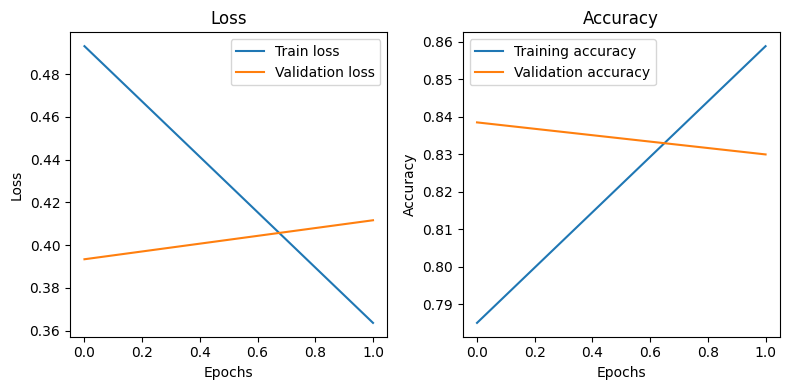

In [ ]:
plot_learning_curves(history.history)

#### 6.2.3.2 Classification Report

The model shows good performance, especially for class 0, with room to improve recall for the minority class. Here, data cleaning improves the predictions, particularly for class 1.

In [ ]:

y_pred_probs = tf_model.predict(tf_eval_dataset).logits

y_pred = np.argmax(y_pred_probs, axis=1)
print(y_pred_probs.shape, y_pred.shape)

24/24 [==============================] - 7s 181ms/step
(1523, 2) (1523,)


In [ ]:
y_true = np.array(val_encoded["labels"])

f1 = f1_score(y_true, y_pred, average='macro')
print("With cleaning f1 :", f1)
print(classification_report(y_true, y_pred))

f1 : 0.8435814310720537
              precision    recall  f1-score   support

           0       0.85      0.90      0.87       874
           1       0.85      0.78      0.81       649

    accuracy                           0.85      1523
   macro avg       0.85      0.84      0.84      1523
weighted avg       0.85      0.85      0.85      1523



Without cleaning:
f1 : 0.8226290514887522


              precision    recall  f1-score   support

           0       0.85      0.84      0.85       874
           1       0.79      0.81      0.80       649

    accuracy                           0.83         1523

#### 6.2.3.3  Confusion matrix

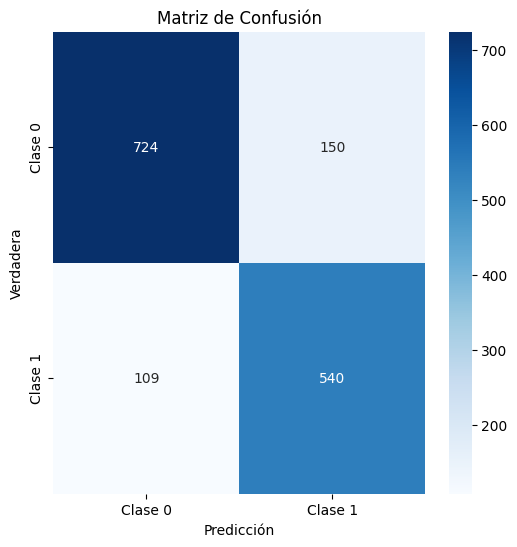

In [ ]:
# Calculate and display the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Clase 0", "Clase 1"], yticklabels=["Clase 0", "Clase 1"])
plt.xlabel("Predicción")
plt.ylabel("Verdadera")
plt.title("Matriz de Confusión")
plt.show()

# 7. Model Inference and Submission

In [ ]:
tf_test_dataset = test_encoded.to_tf_dataset(
    columns=tokenizer_columns,
    shuffle=False,
    batch_size=batch_size
)

In [ ]:
# Predict probabilities on the test dataset
y_test_probs = tf_model.predict(tf_test_dataset).logits

# Convert probabilities to predicted class labels
y_test_pred = np.argmax(y_test_probs, axis=1)

# Prepare and save the submission dataframe
submission=pd.DataFrame({"id":df_test_raw["id"],"target":y_test_pred})
submission.to_csv("submission.csv",index=False)
print("ready!")

51/51 [==============================] - 13s 188ms/step
ready!


P.S. **Thank you for exploring this notebook!** If you found it helpful or interesting, feel free to give it a like. Your feedback is much appreciated!

# 8. Results

At the time of writing this notebook, the position on the leaderboard is 58 out of 924.

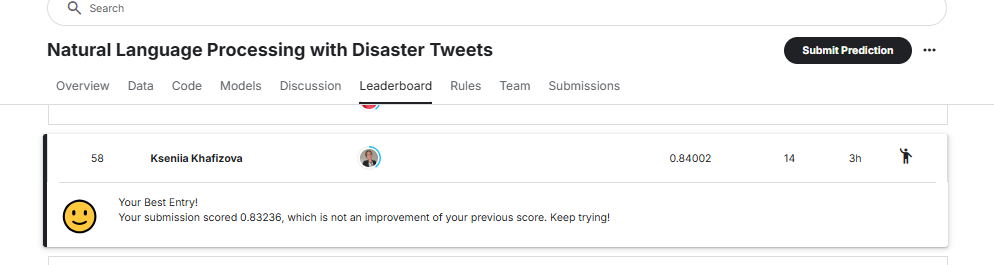